## Introduction/Business Problem
In the last number of years, the topic of homelessness has become a political and news topic in Ireland.  The charity Focus Ireland says that there were 10,448 people homeless across Ireland at the end of 2019 (higher than the official government figure of 6,696 homeless persons), and that the number of homeless families has increased by over 300% since November 2014. In the early 2000's Ireland experienced a property bubble followed by a crash in the 2008 global economic downturn.  Since then, the economy has recovered however rate of new house builds have not kept up with the demand resulting in fewer available rental properties.  One of the many factors cited as influencing the availability of rental properties (and as a result homelessness) is the rise in the number of properties being used for short term rental on Airbnb.  In mid 2019 the Irish government enacted the Residential and Tenancies Act 2019 place restrictions to short-term letting in Rent Pressure Zones. Registrations are limited properties rented out for 90 days or less per year  In this study I will analyse Airbnb rentals and homelessness in two Irish cities:
(1) Dublin which is the capital and largest city in Ireland and the city in which I was born.
(2) Cork which is the second largest city in Ireland and the city in which I currently live and work.
The analysis will be used to determine if any insights linking Airbnb to levels of homelessness can be found and to understand if any properties in Rent Pressure Zones are being let through Airbnb for more than 90 days per year.

## Data
Based on the problem of interest, the information of interest relates to homelessness and Airbnb rentals in the cities of Dublin and Cork.  Folium maps will be used to visualize relevant Airbnb listings in Rent Pressure Zones in Dublin and Cork.
The following data sources will be used to extract the required information and to generate insights:
(1) - Airbnb listings for Dublin and Cork which can be downloaded from the Inside Airbnb website linked below:
http://insideairbnb.com/get-the-data.html
This data includes useful information such as neighbourhood where the property is located (neighbourhood), latitude and longitude, type of property (room_type) as well as number of days per year that the property is available (Availability).
(2) - Official homelessness figures from the Irish Government, Department of Housing, Planning and Local Government available from the website linked below:
https://www.housing.gov.ie/housing/homelessness/other/homelessness-data
(3) New dwelling completiomn data was taken from the Irish Central Statistics Office website linked below:
https://www.cso.ie/en/

In [62]:
# Load & Import Required Libraries
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge folium
import pandas as pd
import numpy as np
from scipy import stats
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



## Generate dataframe of Ireland, Dublin and Cork homeless persons numbers 2014-2019
As there only a small number of data points and the reports containing the official homelessness figures from the Irish Government, Department of Housing,
Planning and Local Government are in pdf format, it was easier to generate the dataframe manually.

In [63]:
# generate Dublin and Cork homeless data lists and dataframe for years 2014-2019
# First generate lists to contain data
hyears = ['2014', '2015', '2016', '2017', '2018', '2019']
irlHome = [2858, 3625, 4643, 5508, 6194, 6696]
dubHome = [1868, 2506, 3162, 3172, 4175, 4534]
corHome =[194, 205, 258, 287, 373, 447]

# Create dataframe of Dublin and Cork Homeless
homeless_df = pd.DataFrame(list(zip(hyears, irlHome, dubHome, corHome)),
                          columns = ('Year', 'Ireland Homeless', 'Dublin Homeless', 'Cork Homeless'))
homeless_df.head(6)

,Year,Ireland Homeless,Dublin Homeless,Cork Homeless
0,2014,2858,1868,194
1,2015,3625,2506,205
2,2016,4643,3162,258
3,2017,5508,3172,287
4,2018,6194,4175,373
5,2019,6696,4534,447


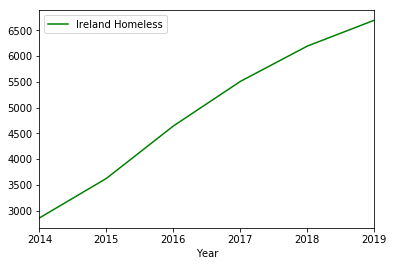

In [64]:
# Generate time series plot of homelessness in Ireland 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Ireland Homeless', color = 'green', ax=ax)
plt.show()

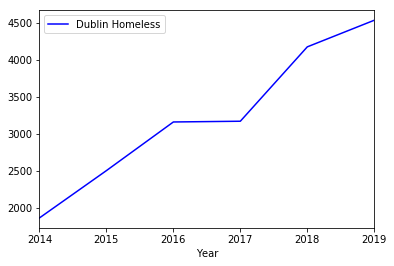

In [65]:
# Generate time series plot of homelessness in Dublin 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Dublin Homeless', color = 'blue', ax=ax)
plt.show()

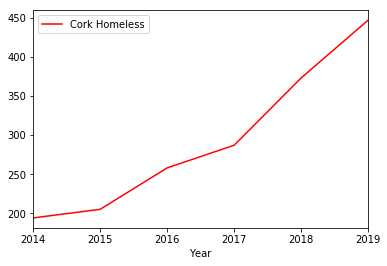

In [66]:
#Generate time series plot of homelessness in Cork 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Cork Homeless', color='red', ax=ax)
plt.show()

As can be seen from the homelessness trends, the number of homeless persons has more than doubled in Ireland, Dublin and Cork in the period of 2014-2019

In [67]:
# Import & clean Ireland new dwelling completions 2000-2012 from CSO website
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
newDwlList_df = pd.read_excel('https://www.cso.ie/en/media/csoie/releasespublications/documents/ep/measuringirelandsprogress/2012/economy/P-MIP2012TBL2.19.xlsx', skiprows=2)

# Eliminate rows with unnecessary data
newDwlList_df = newDwlList_df.drop([0, 1, 2, 3, 4, 5, 19], axis=0).reset_index(drop=True)

# Convert number of dwellings to an integer
newDwlList_df['Number of dwellings'] = newDwlList_df['Number of dwellings'].astype(int)
newDwlList_df.head(30)

,Year,Number of dwellings
0,2000,49812
1,2001,52602
2,2002,57695
3,2003,68819
4,2004,76954
5,2005,85957
6,2006,88419
7,2007,78027
8,2008,51724
9,2009,26420


In [68]:
# generate ireland new dwelling completions data lists and dataframe for years 2013-2019
# This datframe must be created manually as dataset is in pdf format (not a big issue as datset is small)
# First generate lists to contain data
dyears = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
irl_Dwl = [4575, 5518, 7219, 9892, 14368, 17995, 19685]

# Create dataframe of new dwelling completions
newDwl_df = pd.DataFrame(list(zip(dyears, irl_Dwl)),
                          columns = ('Year', 'Number of dwellings'))
newDwl_df.head(7)

,Year,Number of dwellings
0,2013,4575
1,2014,5518
2,2015,7219
3,2016,9892
4,2017,14368
5,2018,17995
6,2019,19685


In [69]:
# Add 2013-2019 dataset to 2000-2012 datset using append function
newDwlFinal_df = newDwlList_df.append(newDwl_df, ignore_index = True)
newDwlFinal_df.head(20)

,Year,Number of dwellings
0,2000,49812
1,2001,52602
2,2002,57695
3,2003,68819
4,2004,76954
5,2005,85957
6,2006,88419
7,2007,78027
8,2008,51724
9,2009,26420


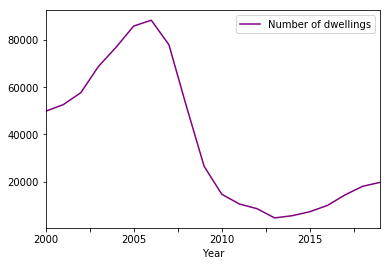

In [70]:
#Generate time series plot of new dwelling completions in Ireland 2011-2019
ax = plt.gca()
newDwlFinal_df.plot(kind='line',x='Year',y='Number of dwellings', color='purple', ax=ax)
plt.show()

As can be seen from the data and time series plot, the number of new dwelling completions hit a low of 4,575 in 2013 (about 4-5 years after the property crash of 2008/2009).
Since then the number of new dwelling completions has accelerated rapidly reaching 19,685 in 2019.
Despite this, the number of new dwelling completions is not keeping up with demand as demonstarted by the increasing numbers of homeless.

## Download & Pre-Process Dublin Airbnb Listings

In [71]:
# Download Dublin Airbnb listings csv file
dubList_url='http://data.insideairbnb.com/ireland/leinster/dublin/2019-11-26/visualisations/listings.csv'
dubList_df = pd.read_csv(dubList_url) 
dubList_df.describe()
dubList_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44077,cosy comfortable Irish cottage twin,193005,Teresa,NaN,Dn Laoghaire-Rathdown,53.28995,-6.25813,Private room,50,3,219,2019-11-25,2.07,3,240
1,85148,Habitación en Dublín Double room,466111,Don,NaN,South Dublin,53.30110,-6.31992,Private room,30,1,1,2019-05-11,0.15,1,24
2,85156,Cosy Comfortable Irish Cottage 1 Double Bed,193005,Teresa,NaN,Dn Laoghaire-Rathdown,53.29178,-6.25618,Private room,50,3,170,2019-11-11,1.64,3,223
3,121030,Comfy double room in central area 1,608225,Norah,NaN,Dublin City,53.33648,-6.22075,Private room,55,2,110,2019-03-19,1.07,3,84
4,159889,Friendly Single Room,766611,Margaret,NaN,Dublin City,53.38988,-6.23620,Private room,29,1,304,2019-11-24,3.25,3,275
5,162809,5.5 miles south of Dublin City :^),777681,Robbie,NaN,Dn Laoghaire-Rathdown,53.28445,-6.19094,Private room,55,1,274,2019-11-10,5.01,2,96
6,165828,Pádraig Pearse apt. Kilmainham,790601,Grainne,NaN,Dublin City,53.33630,-6.32439,Entire home/apt,147,3,43,2019-10-22,0.44,5,280
7,165829,"The ""Michael Collins"" apartment",790601,Grainne,NaN,Dublin City,53.33811,-6.32259,Entire home/apt,135,3,51,2019-06-29,0.53,5,267
8,178860,Georgian House in Heart of City Ctr,856312,Danielle,NaN,Dublin City,53.33282,-6.26821,Private room,56,2,306,2019-11-22,3.48,2,166
9,181823,comfy room near beach/town2,608225,Norah,NaN,Dublin City,53.33650,-6.22066,Private room,75,2,110,2019-11-21,1.11,3,0


There are two types of property available (Private Room and Entire home/apt)
As this study is particularly interested in the impact of Airbnb on available homes to rent,
the number of Entire home/apt is more relevant than the number of Private room.
It was decided to remove the rows with Private Room as the property type.

In [72]:
# Remove rows where the property type is Private Room
dubList2_df = dubList_df[dubList_df.room_type != 'Private room'].reset_index(drop=True)
dubList2_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,165828,Pádraig Pearse apt. Kilmainham,790601,Grainne,NaN,Dublin City,53.33630,-6.32439,Entire home/apt,147,3,43,2019-10-22,0.44,5,280
1,165829,"The ""Michael Collins"" apartment",790601,Grainne,NaN,Dublin City,53.33811,-6.32259,Entire home/apt,135,3,51,2019-06-29,0.53,5,267
2,200979,"""The Lodge, Dalkey Avenue .""",982970,Paul,NaN,Dn Laoghaire-Rathdown,53.27420,-6.10917,Entire home/apt,220,2,141,2019-11-24,1.53,1,232
3,237465,Cozy warm Annexe 10 mins to airport. total pri...,1245198,Amanda,NaN,Dublin City,53.39615,-6.17456,Entire home/apt,55,2,257,2019-11-17,2.66,3,225
4,275425,Luxury family home with all amenities (6 persons),1357428,Emma And Chris,NaN,Dublin City,53.32670,-6.20921,Entire home/apt,248,3,7,2019-07-07,0.07,1,33
5,292757,Old World Converted Stableyard with Swimming Pool,1515549,Sarah,NaN,Fingal,53.36958,-6.34959,Entire home/apt,120,1,317,2019-11-17,3.60,1,144
6,302554,Peaceful retreat for 5 - excellent location,1557844,Liam And Fiona,NaN,Dublin City,53.35628,-6.28981,Entire home/apt,180,2,56,2019-09-25,0.60,8,325
7,302634,Studio sleeps 2 city ctr 10 mins - Molly Malone,1557844,Liam And Fiona,NaN,Dublin City,53.35561,-6.29149,Entire home/apt,100,2,80,2019-09-30,0.85,8,277
8,365854,Boutique Cosy Centre Apartment,1847391,Diane,NaN,Dublin City,53.35305,-6.25708,Entire home/apt,85,2,181,2019-11-10,1.93,1,176
9,374792,"'Grace Gifford' cottage, Kilmainham",790601,Grainne,NaN,Dublin City,53.33680,-6.32410,Entire home/apt,135,3,28,2019-06-30,0.31,5,277


In [73]:
# Remove rows where the availability_365 is zero
dubList3_df = dubList2_df[dubList2_df.availability_365 != 0].reset_index(drop=True)
dubList3_df.describe()
dubList3_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,165828,Pádraig Pearse apt. Kilmainham,790601,Grainne,NaN,Dublin City,53.33630,-6.32439,Entire home/apt,147,3,43,2019-10-22,0.44,5,280
1,165829,"The ""Michael Collins"" apartment",790601,Grainne,NaN,Dublin City,53.33811,-6.32259,Entire home/apt,135,3,51,2019-06-29,0.53,5,267
2,200979,"""The Lodge, Dalkey Avenue .""",982970,Paul,NaN,Dn Laoghaire-Rathdown,53.27420,-6.10917,Entire home/apt,220,2,141,2019-11-24,1.53,1,232
3,237465,Cozy warm Annexe 10 mins to airport. total pri...,1245198,Amanda,NaN,Dublin City,53.39615,-6.17456,Entire home/apt,55,2,257,2019-11-17,2.66,3,225
4,275425,Luxury family home with all amenities (6 persons),1357428,Emma And Chris,NaN,Dublin City,53.32670,-6.20921,Entire home/apt,248,3,7,2019-07-07,0.07,1,33
5,292757,Old World Converted Stableyard with Swimming Pool,1515549,Sarah,NaN,Fingal,53.36958,-6.34959,Entire home/apt,120,1,317,2019-11-17,3.60,1,144
6,302554,Peaceful retreat for 5 - excellent location,1557844,Liam And Fiona,NaN,Dublin City,53.35628,-6.28981,Entire home/apt,180,2,56,2019-09-25,0.60,8,325
7,302634,Studio sleeps 2 city ctr 10 mins - Molly Malone,1557844,Liam And Fiona,NaN,Dublin City,53.35561,-6.29149,Entire home/apt,100,2,80,2019-09-30,0.85,8,277
8,365854,Boutique Cosy Centre Apartment,1847391,Diane,NaN,Dublin City,53.35305,-6.25708,Entire home/apt,85,2,181,2019-11-10,1.93,1,176
9,374792,"'Grace Gifford' cottage, Kilmainham",790601,Grainne,NaN,Dublin City,53.33680,-6.32410,Entire home/apt,135,3,28,2019-06-30,0.31,5,277


Some of the colums are less relevant for the study.
It was decided to clean up the dataframe by removing the following columns:
host_name
neighbourhood_group
minimum_nights
number_of_reviews
last_review
reviews_per_month

In [113]:
dubListFinal_df = dubList3_df.drop(['host_name', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'reviews_per_month','last_review', 'calculated_host_listings_count'], axis=1)
dubListFinal_df.head(10)                                    

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,availability_365
0,165828,Pádraig Pearse apt. Kilmainham,790601,Dublin City,53.33630,-6.32439,Entire home/apt,147,280
1,165829,"The ""Michael Collins"" apartment",790601,Dublin City,53.33811,-6.32259,Entire home/apt,135,267
2,200979,"""The Lodge, Dalkey Avenue .""",982970,Dn Laoghaire-Rathdown,53.27420,-6.10917,Entire home/apt,220,232
3,237465,Cozy warm Annexe 10 mins to airport. total pri...,1245198,Dublin City,53.39615,-6.17456,Entire home/apt,55,225
4,275425,Luxury family home with all amenities (6 persons),1357428,Dublin City,53.32670,-6.20921,Entire home/apt,248,33
5,292757,Old World Converted Stableyard with Swimming Pool,1515549,Fingal,53.36958,-6.34959,Entire home/apt,120,144
6,302554,Peaceful retreat for 5 - excellent location,1557844,Dublin City,53.35628,-6.28981,Entire home/apt,180,325
7,302634,Studio sleeps 2 city ctr 10 mins - Molly Malone,1557844,Dublin City,53.35561,-6.29149,Entire home/apt,100,277
8,365854,Boutique Cosy Centre Apartment,1847391,Dublin City,53.35305,-6.25708,Entire home/apt,85,176
9,374792,"'Grace Gifford' cottage, Kilmainham",790601,Dublin City,53.33680,-6.32410,Entire home/apt,135,277


In [114]:
# Add a new column called max_annual_earnings to dataframe to multiply price by availability_365
dubListFinal_df['max_annual_earnings'] = dubListFinal_df['price']*dubListFinal_df['availability_365']
dubListFinal_df.head(10)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,availability_365,max_annual_earnings
0,165828,Pádraig Pearse apt. Kilmainham,790601,Dublin City,53.33630,-6.32439,Entire home/apt,147,280,41160
1,165829,"The ""Michael Collins"" apartment",790601,Dublin City,53.33811,-6.32259,Entire home/apt,135,267,36045
2,200979,"""The Lodge, Dalkey Avenue .""",982970,Dn Laoghaire-Rathdown,53.27420,-6.10917,Entire home/apt,220,232,51040
3,237465,Cozy warm Annexe 10 mins to airport. total pri...,1245198,Dublin City,53.39615,-6.17456,Entire home/apt,55,225,12375
4,275425,Luxury family home with all amenities (6 persons),1357428,Dublin City,53.32670,-6.20921,Entire home/apt,248,33,8184
5,292757,Old World Converted Stableyard with Swimming Pool,1515549,Fingal,53.36958,-6.34959,Entire home/apt,120,144,17280
6,302554,Peaceful retreat for 5 - excellent location,1557844,Dublin City,53.35628,-6.28981,Entire home/apt,180,325,58500
7,302634,Studio sleeps 2 city ctr 10 mins - Molly Malone,1557844,Dublin City,53.35561,-6.29149,Entire home/apt,100,277,27700
8,365854,Boutique Cosy Centre Apartment,1847391,Dublin City,53.35305,-6.25708,Entire home/apt,85,176,14960
9,374792,"'Grace Gifford' cottage, Kilmainham",790601,Dublin City,53.33680,-6.32410,Entire home/apt,135,277,37395


In [76]:
# Inspect the Dublin Airbnb Listings dataset
dubListFinal_df.describe()

,id,host_id,latitude,longitude,price,availability_365,max_annual_earnings
count,2.912000e+03,2.912000e+03,2912.000000,2912.000000,2912.000000,2912.000000,2.912000e+03
mean,2.445844e+07,1.003200e+08,53.344722,-6.252321,189.008585,136.196429,2.832478e+04
std,1.097213e+07,9.012047e+07,0.040621,0.052371,282.576011,115.914312,4.779030e+04
min,1.658280e+05,1.922100e+05,53.211130,-6.519370,10.000000,1.000000,4.000000e+01
25%,1.637653e+07,2.414125e+07,53.331815,-6.274235,98.000000,37.000000,4.274250e+03
50%,2.540806e+07,6.857736e+07,53.343910,-6.260060,140.000000,91.000000,1.391000e+04
75%,3.429921e+07,1.624024e+08,53.353450,-6.238465,200.000000,231.250000,3.240000e+04
max,4.037631e+07,3.120656e+08,53.606000,-6.025940,8956.000000,365.000000,1.128400e+06


In [77]:
print(dubListFinal_df.shape)

(2912, 10)


There are a total of 2,912 relevant Airbnb listings in Dublin which are not single rooms.
As the number of homeless in Dublin is 4,534 persons, even if all of these properties were freed up
for long term rental, it is unlikley that these would resolve the homelessness issue.
However if we assume that some of the people listed as homeless are family groups, freeing up some of these
properties for homeless family long term rental could help alleviate the homelessness issue.

In [78]:
# Check the number of Dublin Airbnb listings that exceed the 90 day cap for rent pressure zones set by the new Irish government legislation
dubList90_df = dubListFinal_df[dubListFinal_df['availability_365']>90]
print(dubList90_df.shape)

(1462, 10)


This is interesting as it indicates that 1,462 of the 2,912 listings (approx. 50%) exceed the 90 day cap set by the new government legislation.
This may be due to the law being new and not being fully understood by landlords and not yet being strongly enforced by local government.

## Download & Pre-Process Cork Airbnb Listings

Because Cork is a much smaller city than Dublin, and very small by international standards there is no separate Airbnb listings dataset available for Cork.
It will be necessary to download the Ireland dataset and extract the Cork city data from it.

In [79]:
# Download Ireland Airbnb listings csv file
ireList_url='http://data.insideairbnb.com/ireland/2019-11-23/visualisations/listings.csv'
ireList_df = pd.read_csv(ireList_url) 
ireList_df.describe()
ireList_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,calculated_host_listings_count,availability_365
0,20436982,"Close to city centre, situated in charming vil...",14893205,Laura,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.34940,-6.34664,Entire home/apt,90,1,11,0,2018-09-18,1,0
1,39364220,The perfect Dublin apartment!,302362865,James Alex,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.34772,-6.34647,Entire home/apt,110,3,1,1,2019-11-17,1,20
2,16263733,Double bedroom next to Phoenix park,42059994,Nastasia,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.34239,-6.32926,Private room,39,1,0,0,NaN,2,0
3,40138082,Bright home in a quiet neighbourhood.,172538850,Maeve,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.32258,-6.32710,Entire home/apt,120,2,0,0,NaN,1,18
4,3581384,"CONTEMPORARY 3 BEDROOM TOWNHOUSE CENTRAL, SLEE...",17981524,Christina,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.32697,-6.31395,Entire home/apt,175,15,20,9,2019-08-18,5,0
5,21167665,Doble bedroom in walkinstown,24183424,Marcos,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.31961,-6.32238,Private room,40,3,1,0,2017-10-14,2,0
6,15464515,"Iveagh Cottage, 3 bedroom warm house with garden",97033971,Celine,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.32899,-6.31619,Entire home/apt,167,2,8,0,2018-03-08,1,365
7,37226483,A modern 3 bed home with easy access to the city,20214456,Mark,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.31804,-6.32237,Entire home/apt,150,2,2,2,2019-11-02,2,0
8,13620699,1 bedroom Apt. with full facilities. Close to ...,78889552,Mary,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.34563,-6.34237,Entire home/apt,50,1,3,0,2017-09-03,1,0
9,13759419,3 Bed Ensuited Space Free Parking & City Tram ...,37019750,Sammy,Dublin City Council,Ballyfermot-Drimnagh LEA-5,53.33509,-6.32970,Entire home/apt,80,2,18,14,2019-11-17,1,108


In [80]:
# Extract Cork city council entries from the dataset
ireList2_df = ireList_df.loc[ireList_df['neighbourhood_group'].isin(['Cork City Council'])].reset_index(drop=True)
ireList2_df.describe()
ireList2_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,calculated_host_listings_count,availability_365
0,39663754,Matress and sofa for budget traveller,81353277,卓霖,Cork City Council,Cork City South Central LEA-6,51.89433,-8.49582,Private room,25,1,1,1,2019-11-10,2,0
1,9548704,modern open plan 2 bed house,49447447,Fiona,Cork City Council,Cork City South Central LEA-6,51.89126,-8.46324,Entire home/apt,125,3,88,13,2019-10-20,1,342
2,13344373,House in Cork City centre - 3 rooms,58764063,David,Cork City Council,Cork City South Central LEA-6,51.88995,-8.47027,Entire home/apt,125,2,11,2,2019-07-07,1,168
3,17735027,Modern & quiet double bed room in Cork City Ce...,33304958,Justine,Cork City Council,Cork City South Central LEA-6,51.89922,-8.47273,Private room,50,1,16,16,2019-09-16,1,0
4,40010839,Cork City Centre Accommodation,39466924,Sharon,Cork City Council,Cork City South Central LEA-6,51.89304,-8.48385,Private room,90,30,0,0,NaN,2,113
5,20578464,Modern bedroom with private bathroom,13108197,Jennifer,Cork City Council,Cork City South Central LEA-6,51.89611,-8.46584,Private room,60,3,73,26,2019-08-01,1,0
6,33509612,Home from home near Cork City and Airport,252273604,Dee,Cork City Council,Cork City South Central LEA-6,51.86900,-8.46627,Private room,45,2,16,16,2019-10-03,2,1
7,27196730,City centre 1 bedroom apartment own door un...,107437226,Anthony,Cork City Council,Cork City South Central LEA-6,51.89633,-8.48618,Entire home/apt,85,1,121,88,2019-11-01,6,160
8,3088179,Private Double Room Apartment in the heart of ...,193834,Maria,Cork City Council,Cork City South Central LEA-6,51.89269,-8.47284,Entire home/apt,49,2,260,62,2019-11-24,1,184
9,32834364,"3 Altona college road, cork city",56311866,Conor,Cork City Council,Cork City South Central LEA-6,51.89221,-8.48773,Entire home/apt,160,3,4,4,2019-08-11,3,0


In [81]:
# Remove rows where the property type is Private Room
ireList3_df = ireList2_df[ireList2_df.room_type != 'Private room'].reset_index(drop=True)
ireList3_df.describe()
ireList3_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,calculated_host_listings_count,availability_365
0,9548704,modern open plan 2 bed house,49447447,Fiona,Cork City Council,Cork City South Central LEA-6,51.89126,-8.46324,Entire home/apt,125,3,88,13,2019-10-20,1,342
1,13344373,House in Cork City centre - 3 rooms,58764063,David,Cork City Council,Cork City South Central LEA-6,51.88995,-8.47027,Entire home/apt,125,2,11,2,2019-07-07,1,168
2,27196730,City centre 1 bedroom apartment own door un...,107437226,Anthony,Cork City Council,Cork City South Central LEA-6,51.89633,-8.48618,Entire home/apt,85,1,121,88,2019-11-01,6,160
3,3088179,Private Double Room Apartment in the heart of ...,193834,Maria,Cork City Council,Cork City South Central LEA-6,51.89269,-8.47284,Entire home/apt,49,2,260,62,2019-11-24,1,184
4,32834364,"3 Altona college road, cork city",56311866,Conor,Cork City Council,Cork City South Central LEA-6,51.89221,-8.48773,Entire home/apt,160,3,4,4,2019-08-11,3,0
5,25505651,City Centre Apartment,192477332,Alma,Cork City Council,Cork City South Central LEA-6,51.89704,-8.47654,Entire home/apt,91,2,54,18,2019-03-13,1,0
6,24804603,One bedroom flat in listed Georgian house,907742,John,Cork City Council,Cork City South Central LEA-6,51.88932,-8.46825,Entire home/apt,52,15,101,55,2019-09-29,4,90
7,38741027,Newly Built 5 Bedroom City Center Apartment,296266292,Lee Point,Cork City Council,Cork City South Central LEA-6,51.89623,-8.47748,Entire home/apt,400,1,0,0,NaN,3,90
8,15388361,9 Magazine rd cork city,56311866,Conor,Cork City Council,Cork City South Central LEA-6,51.88914,-8.50054,Entire home/apt,175,2,23,7,2019-08-17,3,37
9,36666968,Gems Place - Modern Apartment.,42822025,Gem,Cork City Council,Cork City South Central LEA-6,51.86630,-8.46725,Entire home/apt,76,2,43,43,2019-11-23,4,287


In [82]:
# Remove rows where the availability_365 is zero
ireList4_df = ireList3_df[ireList3_df.availability_365 != 0].reset_index(drop=True)
ireList4_df.describe()
ireList4_df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,calculated_host_listings_count,availability_365
0,9548704,modern open plan 2 bed house,49447447,Fiona,Cork City Council,Cork City South Central LEA-6,51.89126,-8.46324,Entire home/apt,125,3,88,13,2019-10-20,1,342
1,13344373,House in Cork City centre - 3 rooms,58764063,David,Cork City Council,Cork City South Central LEA-6,51.88995,-8.47027,Entire home/apt,125,2,11,2,2019-07-07,1,168
2,27196730,City centre 1 bedroom apartment own door un...,107437226,Anthony,Cork City Council,Cork City South Central LEA-6,51.89633,-8.48618,Entire home/apt,85,1,121,88,2019-11-01,6,160
3,3088179,Private Double Room Apartment in the heart of ...,193834,Maria,Cork City Council,Cork City South Central LEA-6,51.89269,-8.47284,Entire home/apt,49,2,260,62,2019-11-24,1,184
4,24804603,One bedroom flat in listed Georgian house,907742,John,Cork City Council,Cork City South Central LEA-6,51.88932,-8.46825,Entire home/apt,52,15,101,55,2019-09-29,4,90
5,38741027,Newly Built 5 Bedroom City Center Apartment,296266292,Lee Point,Cork City Council,Cork City South Central LEA-6,51.89623,-8.47748,Entire home/apt,400,1,0,0,NaN,3,90
6,15388361,9 Magazine rd cork city,56311866,Conor,Cork City Council,Cork City South Central LEA-6,51.88914,-8.50054,Entire home/apt,175,2,23,7,2019-08-17,3,37
7,36666968,Gems Place - Modern Apartment.,42822025,Gem,Cork City Council,Cork City South Central LEA-6,51.86630,-8.46725,Entire home/apt,76,2,43,43,2019-11-23,4,287
8,17311815,Cork City Centre Bright & Airy 2 Bedroom Duplex,116823097,Susan,Cork City Council,Cork City South Central LEA-6,51.89624,-8.46968,Entire home/apt,120,2,295,106,2019-11-24,1,60
9,19499792,"Self catering 'Luxury' 1, 2 or3 bedroom Suite",136913954,Brian,Cork City Council,Cork City South Central LEA-6,51.89426,-8.49226,Entire home/apt,188,1,123,42,2019-11-16,3,355


In [83]:
# Remove the uneccessary LEA-6 & LEA-7 suffix on the neighbourhood names
ireList4_df['neighbourhood'] = ireList4_df['neighbourhood'].map(lambda x: x.rstrip('LEA-6'))
ireList4_df['neighbourhood'] = ireList4_df['neighbourhood'].map(lambda x: x.rstrip('LEA-7'))
ireList4_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,calculated_host_listings_count,availability_365
0,9548704,modern open plan 2 bed house,49447447,Fiona,Cork City Council,Cork City South Central,51.89126,-8.46324,Entire home/apt,125,3,88,13,2019-10-20,1,342
1,13344373,House in Cork City centre - 3 rooms,58764063,David,Cork City Council,Cork City South Central,51.88995,-8.47027,Entire home/apt,125,2,11,2,2019-07-07,1,168
2,27196730,City centre 1 bedroom apartment own door un...,107437226,Anthony,Cork City Council,Cork City South Central,51.89633,-8.48618,Entire home/apt,85,1,121,88,2019-11-01,6,160
3,3088179,Private Double Room Apartment in the heart of ...,193834,Maria,Cork City Council,Cork City South Central,51.89269,-8.47284,Entire home/apt,49,2,260,62,2019-11-24,1,184
4,24804603,One bedroom flat in listed Georgian house,907742,John,Cork City Council,Cork City South Central,51.88932,-8.46825,Entire home/apt,52,15,101,55,2019-09-29,4,90


In [84]:
# Remove unnecessary columns to generate final Cork listings dataframe with the same format as the final Dublin listings dataframe
corListFinal_df = ireList4_df.drop(['host_name', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'number_of_reviews', 'number_of_reviews_ltm', 'last_review', 'calculated_host_listings_count',], axis=1).reset_index(drop=True)
corListFinal_df.head(10)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,availability_365
0,9548704,modern open plan 2 bed house,49447447,Cork City South Central,51.89126,-8.46324,Entire home/apt,125,342
1,13344373,House in Cork City centre - 3 rooms,58764063,Cork City South Central,51.88995,-8.47027,Entire home/apt,125,168
2,27196730,City centre 1 bedroom apartment own door un...,107437226,Cork City South Central,51.89633,-8.48618,Entire home/apt,85,160
3,3088179,Private Double Room Apartment in the heart of ...,193834,Cork City South Central,51.89269,-8.47284,Entire home/apt,49,184
4,24804603,One bedroom flat in listed Georgian house,907742,Cork City South Central,51.88932,-8.46825,Entire home/apt,52,90
5,38741027,Newly Built 5 Bedroom City Center Apartment,296266292,Cork City South Central,51.89623,-8.47748,Entire home/apt,400,90
6,15388361,9 Magazine rd cork city,56311866,Cork City South Central,51.88914,-8.50054,Entire home/apt,175,37
7,36666968,Gems Place - Modern Apartment.,42822025,Cork City South Central,51.86630,-8.46725,Entire home/apt,76,287
8,17311815,Cork City Centre Bright & Airy 2 Bedroom Duplex,116823097,Cork City South Central,51.89624,-8.46968,Entire home/apt,120,60
9,19499792,"Self catering 'Luxury' 1, 2 or3 bedroom Suite",136913954,Cork City South Central,51.89426,-8.49226,Entire home/apt,188,355


In [85]:
# Add a new column called max_annual_earnings to dataframe to multiply price by availability_365
corListFinal_df['max_annual_earnings'] = corListFinal_df['price']*corListFinal_df['availability_365']
corListFinal_df.head(10)

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,availability_365,max_annual_earnings
0,9548704,modern open plan 2 bed house,49447447,Cork City South Central,51.89126,-8.46324,Entire home/apt,125,342,42750
1,13344373,House in Cork City centre - 3 rooms,58764063,Cork City South Central,51.88995,-8.47027,Entire home/apt,125,168,21000
2,27196730,City centre 1 bedroom apartment own door un...,107437226,Cork City South Central,51.89633,-8.48618,Entire home/apt,85,160,13600
3,3088179,Private Double Room Apartment in the heart of ...,193834,Cork City South Central,51.89269,-8.47284,Entire home/apt,49,184,9016
4,24804603,One bedroom flat in listed Georgian house,907742,Cork City South Central,51.88932,-8.46825,Entire home/apt,52,90,4680
5,38741027,Newly Built 5 Bedroom City Center Apartment,296266292,Cork City South Central,51.89623,-8.47748,Entire home/apt,400,90,36000
6,15388361,9 Magazine rd cork city,56311866,Cork City South Central,51.88914,-8.50054,Entire home/apt,175,37,6475
7,36666968,Gems Place - Modern Apartment.,42822025,Cork City South Central,51.86630,-8.46725,Entire home/apt,76,287,21812
8,17311815,Cork City Centre Bright & Airy 2 Bedroom Duplex,116823097,Cork City South Central,51.89624,-8.46968,Entire home/apt,120,60,7200
9,19499792,"Self catering 'Luxury' 1, 2 or3 bedroom Suite",136913954,Cork City South Central,51.89426,-8.49226,Entire home/apt,188,355,66740


In [86]:
# Inspect the Cork Airbnb Listings dataset
corListFinal_df.describe()

,id,host_id,latitude,longitude,price,availability_365,max_annual_earnings
count,1.780000e+02,1.780000e+02,178.000000,178.000000,178.000000,178.000000,178.000000
mean,2.592194e+07,9.845497e+07,51.896259,-8.468609,120.977528,174.511236,22321.994382
std,9.973798e+06,8.846174e+07,0.017187,0.036348,64.022238,116.717063,22108.631742
min,3.493120e+05,1.938340e+05,51.849730,-8.599050,30.000000,1.000000,70.000000
25%,1.864586e+07,2.839399e+07,51.888747,-8.479360,80.000000,71.000000,6186.250000
50%,2.668437e+07,6.555958e+07,51.897095,-8.470430,101.500000,166.000000,16000.000000
75%,3.437753e+07,1.578767e+08,51.903295,-8.452690,145.000000,300.000000,30952.500000
max,4.027582e+07,3.030647e+08,51.950080,-8.379510,400.000000,358.000000,122150.000000


In [87]:
print(corListFinal_df.shape)

(178, 10)


There are a total of 178 relevant Airbnb listings in Cork which are not single rooms.
As the number of homeless in Cork is 447 persons, even if all of these properties were freed up
for long term rental, it would resolve the homelessness issue.
However if we assume that some of the people listed as homeless are family groups, freeing up some of these
properties for homeless family long term rental could help alleviate the homelessness issue.

In [88]:
# Check the number of Cork Airbnb listings that exceed the 90 day cap for rent pressure zones set by the new Irish government legislation
corList90_df = corListFinal_df[corListFinal_df['availability_365']>90]
print(corList90_df.shape)

(119, 10)


Interestingly, 119 of the 178 listings (approx. 67%) exceed the 90 day cap set by the new government legislation.
This may be due to the law being new and not being fully understood by landlords and not yet being strongly enforced by local government.

## Further Analysis of Dublin and Cork Listings by Neighbourhood

In [89]:
# show unique neighbourhoods in Dublin
print(dubListFinal_df.neighbourhood.unique())

['Dublin City' 'Dn Laoghaire-Rathdown' 'Fingal' 'South Dublin']


Text(0, 0.5, 'Number of Listings')

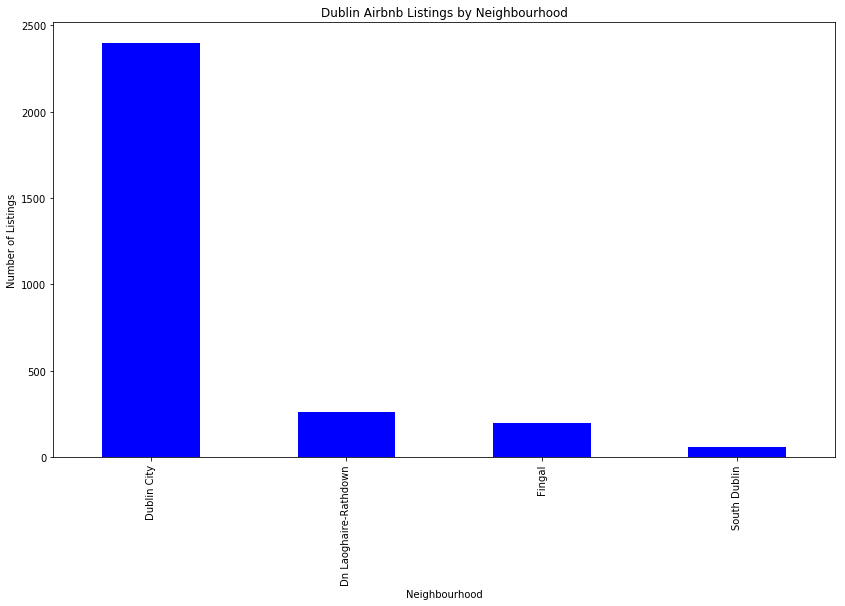

In [90]:
# Generate bar chart to show number of relevant listings in Dublin by neighbourhooddf = df.replace(np.nan,0)
dubHist_df = dubListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Dublin Airbnb Listings by Neighbourhood")
dubHist_df.set_xlabel("Neighbourhood")
dubHist_df.set_ylabel("Number of Listings")

In [91]:
# Determine mean, median, maximum and minimum max_annual_earnings for Dublin
# mean Dublin max_annual_earnings by neighbourhood
dubMean = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(dubMean))

neighbourhood
Dn Laoghaire-Rathdown    28899.0
Dublin City              28849.0
Fingal                   22708.0
South Dublin             23232.0
Name: max_annual_earnings, dtype: float64


In [92]:
# median Dublin max_annual_earnings by neighbourhood
dubMedian = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].median()
print(round(dubMedian))

neighbourhood
Dn Laoghaire-Rathdown    15990.0
Dublin City              13400.0
Fingal                   16272.0
South Dublin              9654.0
Name: max_annual_earnings, dtype: float64


In [93]:
# maximum max_annual_earnings Dublin by neighbourhood
dubMax = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].max()
print(round(dubMax))

neighbourhood
Dn Laoghaire-Rathdown     345000
Dublin City              1128400
Fingal                    235200
South Dublin              327000
Name: max_annual_earnings, dtype: int64


In [94]:
# minimum max_annual_earnings Dublin by neighbourhood
dubMin = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].min()
print(round(dubMin))

neighbourhood
Dn Laoghaire-Rathdown    150
Dublin City               40
Fingal                    90
South Dublin              76
Name: max_annual_earnings, dtype: int64


In [95]:
# Create dataframe to summarize Dublin max_annual_earning statistics
neighbourhood = ['Dun Laoghaire Rathdown', 'Dublin City', 'Fingal', 'South Dublin']
dubStat = pd.DataFrame(list(zip(neighbourhood, round(dubMean), round(dubMedian), round(dubMax), round(dubMin))),
                      columns =['Neighbourhood', 'Mean', 'Median', 'Maximum', 'Minimum'])
dubStat.head()

,Neighbourhood,Mean,Median,Maximum,Minimum
0,Dun Laoghaire Rathdown,28899.0,15990.0,345000,150
1,Dublin City,28849.0,13400.0,1128400,40
2,Fingal,22708.0,16272.0,235200,90
3,South Dublin,23232.0,9654.0,327000,76


In [96]:
# Create bar chart of max_earnings by Dublin neighbourhood
dubStatHist = dubStat['Neighbourhood'].dubStat['Median'].plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Dublin Airbnb max_annual_earnings by Neighbourhood")
dubHist_df.set_xlabel("Neighbourhood")
dubHist_df.set_ylabel("Max_annual_earnings")

# Generate bar chart to show number of relevant listings in Dublin by neighbourhooddf = df.replace(np.nan,0)
dubHist_df = dubListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Dublin Airbnb Listings by Neighbourhood")
dubHist_df.set_xlabel("Neighbourhood")
dubHist_df.set_ylabel("Number of Listings")

AttributeError: 'Series' object has no attribute 'dubStat'

In [97]:
# show unique neighbourhoods in Cork
print(corListFinal_df.neighbourhood.unique())

['Cork City South Central ' 'Cork City North East '
 'Cork City North West ' 'Cork City South West ' 'Cork City South East ']


Text(0, 0.5, 'Number of Listings')

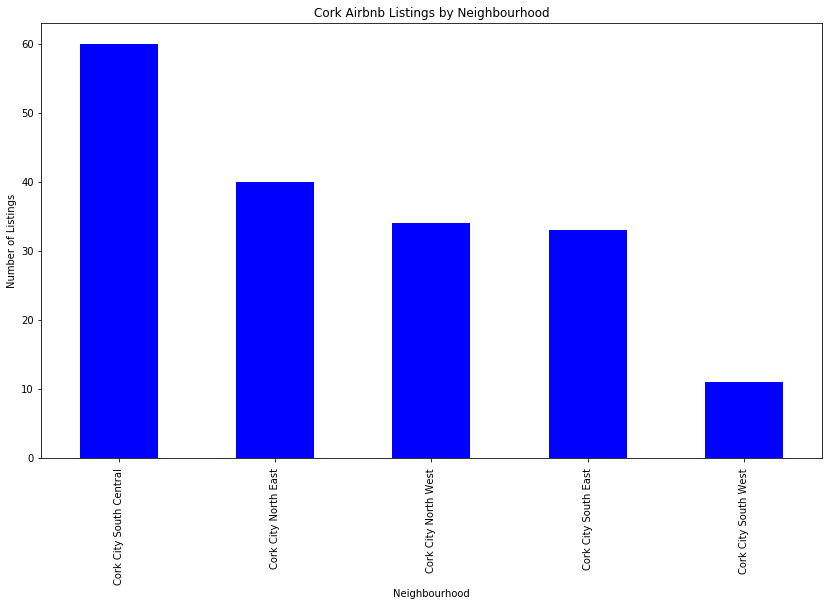

In [98]:
# Generate histogram to show number of relevant listings in Cork by neighbourhood
corHist_df = corListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Cork Airbnb Listings by Neighbourhood")
corHist_df.set_xlabel("Neighbourhood")
corHist_df.set_ylabel("Number of Listings")

In [99]:
# Determine mean, median, maximum and minimum max_annual_earnings by neighbourhood for Cork
# mean Cork max_annual_earnings by neighbourhood
corMean = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(corMean))

neighbourhood
Cork City North East        26679.0
Cork City North West        20056.0
Cork City South Central     21003.0
Cork City South East        21377.0
Cork City South West        23515.0
Name: max_annual_earnings, dtype: float64


In [100]:
# median Cork max_annual_earnings by neighbourhood
corMedian = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(corMedian))

neighbourhood
Cork City North East        26679.0
Cork City North West        20056.0
Cork City South Central     21003.0
Cork City South East        21377.0
Cork City South West        23515.0
Name: max_annual_earnings, dtype: float64


In [101]:
# max Cork max_annual_earnings by neighbourhood
corMax = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].max()
print(round(corMax))

neighbourhood
Cork City North East        122150
Cork City North West         84250
Cork City South Central     109800
Cork City South East         60400
Cork City South West        110360
Name: max_annual_earnings, dtype: int64


In [102]:
# min Cork max_annual_earnings by neighbourhood
corMin = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].min()
print(round(corMin))

neighbourhood
Cork City North East         70
Cork City North West        325
Cork City South Central     639
Cork City South East        524
Cork City South West        120
Name: max_annual_earnings, dtype: int64


In [103]:
# Create dataframe to summarize Cork max_annual_earning statistics
neighbourhoodC = ['Cork City North East', 'Cork City North West', 'Cork City South Central', 'Cork City South East', 'Cork City South West']
corStat = pd.DataFrame(list(zip(neighbourhoodC, round(corMean), round(corMedian), round(corMax), round(corMin))),
                      columns =['Neighbourhood', 'Mean', 'Median', 'Maximum', 'Minimum'])
corStat.head()

,Neighbourhood,Mean,Median,Maximum,Minimum
0,Cork City North East,26679.0,26679.0,122150,70
1,Cork City North West,20056.0,20056.0,84250,325
2,Cork City South Central,21003.0,21003.0,109800,639
3,Cork City South East,21377.0,21377.0,60400,524
4,Cork City South West,23515.0,23515.0,110360,120


In [104]:
## Generate Maps of Dublin and Cork with neighbourhoods

In [105]:
# Use geopy library to get geographical co-ordinates for Dublin
address = 'Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
dublatitude = location.latitude
dublongitude = location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(dublatitude, dublongitude))


The geograpical coordinate of Dublin are 53.3497645, -6.2602732.


In [118]:
# Create folium map for Dublin
dub_map = folium.Map(location=[dublatitude, dublongitude], zoom_start=11)
dub_map

In [191]:
# Generate a reduced dataset of 1,000 listings for visualization purposes as 2,912 listings are too large to visualize on a folium map
reddubListFinal_df = dubListFinal_df.head(1000)

# Add markers to the Dublin map for each of the Airbnb Listings
for dlat, dlong, dident in zip(reddubListFinal_df['latitude'], reddubListFinal_df['longitude'], reddubListFinal_df['id']):
    label = "{}".format(dident)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [dlat, dlong],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(dub_map)
    
dub_map

As expected from previous histogram, the majority of the Dublin listings are clustered around Dublin City Centre.
It is not surprising as Dublin has many tourist attractions, restuarants bars etc.
Looking a bit closer, there appear to be clusters around the Temple Bar, Smithfield and Hanover Quay

## Use Foursquare API to explore venues in Dublin City Centre, Temple Bar, Smithfield & Hanover Quay

In [164]:
# Use geopy library to get geographical co-ordinates for The Temple Bar, Dublin
address = 'Temple Bar, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
templatitude = location.latitude
templongitude = location.longitude
print('The geograpical coordinate of Temple Bar, Dublin are {}, {}.'.format(templatitude, templongitude))

The geograpical coordinate of Temple Bar, Dublin are 53.3452461, -6.264157278134605.


In [166]:
#Use geopy library to get geographical co-ordinates for Smithfield, Dublin
address = 'Smithfield, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
smithlatitude = location.latitude
smithlongitude = location.longitude
print('The geograpical coordinate of Smithfield, Dublin are {}, {}.'.format(smithlatitude, smithlongitude))

The geograpical coordinate of Smithfield, Dublin are 53.3484314, -6.2782374.


In [167]:
#Use geopy library to get geographical co-ordinates for Hanover Quay, Dublin
address = 'Hanover Quay, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
hanlatitude = location.latitude
hanlongitude = location.longitude
print('The geograpical coordinate of Hanover Quay, Dublin are {}, {}.'.format(hanlatitude, hanlongitude))

The geograpical coordinate of Hanover Quay, Dublin are 53.343866, -6.2334691.


In [174]:
# Access Foursquare API

CLIENT_ID = 'JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1' # your Foursquare ID
CLIENT_SECRET = 'U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS' # your Foursquare Secret

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VERSION = '20200202'

Your credentials:
CLIENT_ID: JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1
CLIENT_SECRET:U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS


In [175]:
# Create radius of 1km and limit of 100 venues
radius = 1000
LIMIT = 100

In [ ]:
# create the API request URL to serach for venues in Dublin City Centre
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    dublatitude,
    dublongitude,
    radius,
    LIMIT)
dubccresults = requests.get(url).json() 
dubccresults

In [ ]:
# assign relevant part of JSON to Dublin City Centre venues
dubccvenues = dubccresults['response']['venues']

# tranform venues into a dataframe
dubcc_df = json_normalize(dubccvenues)
dubcc_df.head()

In [ ]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dubcc_df.columns if col.startswith('location.')] + ['id']
dubcc_df_filtered = dubcc_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dubcc_df_filtered['categories'] = dubcc_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dubcc_df_filtered.columns = [column.split('.')[-1] for column in dubcc_df_filtered.columns]

dubcc_df_filtered.head()

In [176]:
# create the API request URL to serach for venues in Temple Bar
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    templatitude,
    templongitude,
    radius,
    LIMIT)
tempresults = requests.get(url).json() 
tempresults

{'meta': {'code': 200, 'requestId': '5e372a6047e0d6001b78d4dd'},
 'response': {'venues': [{'id': '4ade0ef0f964a520817021e3',
    'name': 'The Temple Bar',
    'location': {'address': '47-48 Temple Bar',
     'lat': 53.3454766557522,
     'lng': -6.264191652531398,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.3454766557522,
       'lng': -6.264191652531398}],
     'distance': 25,
     'postalCode': '2',
     'cc': 'IE',
     'neighborhood': 'Temple Bar',
     'city': 'Dublin',
     'state': 'Dublin City',
     'country': 'Ireland',
     'formattedAddress': ['47-48 Temple Bar',
      'Dublin',
      'Dublin City',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d11b941735',
      'name': 'Pub',
      'pluralName': 'Pubs',
      'shortName': 'Pub',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580673682',
    'hasPerk': False},
   {'id': '4bed653e3372c9

In [177]:
# assign relevant part of JSON to Temple Bar venues
tempvenues = tempresults['response']['venues']

# tranform venues into a dataframe
temp_df = json_normalize(tempvenues)
temp_df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",False,4ade0ef0f964a520817021e3,47-48 Temple Bar,IE,Dublin,Ireland,NaN,25,"[47-48 Temple Bar, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.3454766557522,...",53.345477,-6.264192,Temple Bar,2,Dublin City,The Temple Bar,v-1580673682,NaN
1,"[{'id': '5032792091d4c4b30a586d5c', 'name': 'C...",False,4bed653e3372c9281c891114,"Curved St, Temple Bar",IE,Dublin,Ireland,NaN,33,"[Curved St, Temple Bar, Dublin, Dublin City, I...","[{'label': 'display', 'lat': 53.34495335512381...",53.344953,-6.264283,NaN,D2,Dublin City,Temple Bar Music Centre,v-1580673682,NaN
2,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",False,4af2cc8cf964a5208ce821e3,Cearnóg Bharra an Teampaill,IE,Dublin,Ireland,NaN,80,"[Cearnóg Bharra an Teampaill, Dublin, Dublin C...","[{'label': 'display', 'lat': 53.34552023801191...",53.345520,-6.263035,NaN,2,Dublin City,Temple Bar Square,v-1580673682,NaN
3,"[{'id': '4bf58dd8d48988d1ee931735', 'name': 'H...",False,4ade0ed7f964a520167021e3,19 Temple Ln S,IE,Dublin,Ireland,NaN,18,"[19 Temple Ln S, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34508483207718...",53.345085,-6.264122,NaN,2,Dublin City,Barnacles Hostel,v-1580673682,NaN
4,"[{'id': '4bf58dd8d48988d1e5931735', 'name': 'M...",False,4ade0ef4f964a520907021e3,Curved St,IE,Dublin,Ireland,NaN,22,"[Curved St, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34506056892914...",53.345061,-6.264301,NaN,2,Dublin City,The Button Factory,v-1580673682,NaN


In [178]:
print(temp_df.shape)

(100, 19)


In [180]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in temp_df.columns if col.startswith('location.')] + ['id']
temp_df_filtered = temp_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
temp_df_filtered['categories'] = temp_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
temp_df_filtered.columns = [column.split('.')[-1] for column in temp_df_filtered.columns]

temp_df_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,The Temple Bar,Pub,47-48 Temple Bar,IE,Dublin,Ireland,NaN,25,"[47-48 Temple Bar, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.3454766557522,...",53.345477,-6.264192,Temple Bar,2,Dublin City,4ade0ef0f964a520817021e3
1,Temple Bar Music Centre,Concert Hall,"Curved St, Temple Bar",IE,Dublin,Ireland,NaN,33,"[Curved St, Temple Bar, Dublin, Dublin City, I...","[{'label': 'display', 'lat': 53.34495335512381...",53.344953,-6.264283,NaN,D2,Dublin City,4bed653e3372c9281c891114
2,Temple Bar Square,Plaza,Cearnóg Bharra an Teampaill,IE,Dublin,Ireland,NaN,80,"[Cearnóg Bharra an Teampaill, Dublin, Dublin C...","[{'label': 'display', 'lat': 53.34552023801191...",53.345520,-6.263035,NaN,2,Dublin City,4af2cc8cf964a5208ce821e3
3,Barnacles Hostel,Hostel,19 Temple Ln S,IE,Dublin,Ireland,NaN,18,"[19 Temple Ln S, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34508483207718...",53.345085,-6.264122,NaN,2,Dublin City,4ade0ed7f964a520167021e3
4,The Button Factory,Music Venue,Curved St,IE,Dublin,Ireland,NaN,22,"[Curved St, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34506056892914...",53.345061,-6.264301,NaN,2,Dublin City,4ade0ef4f964a520907021e3


In [179]:
# Remove unnecessary columns to generate final TempleBar venues listings dataframe
tempFinal_df = temp_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
tempFinal_df

,name,categories,address,distance,lat,lng,id
0,The Temple Bar,Pub,47-48 Temple Bar,25,53.345477,-6.264192,4ade0ef0f964a520817021e3
1,Temple Bar Music Centre,Concert Hall,"Curved St, Temple Bar",33,53.344953,-6.264283,4bed653e3372c9281c891114
2,Temple Bar Square,Plaza,Cearnóg Bharra an Teampaill,80,53.345520,-6.263035,4af2cc8cf964a5208ce821e3
3,Barnacles Hostel,Hostel,19 Temple Ln S,18,53.345085,-6.264122,4ade0ed7f964a520167021e3
4,The Button Factory,Music Venue,Curved St,22,53.345061,-6.264301,4ade0ef4f964a520907021e3
5,Pablo Picante,Burrito Place,22 Temple Bar,154,53.345667,-6.261936,503224d8e4b07f473b1be4ef
6,The North Face,Clothing Store,17-18 Temple Ln S,13,53.345357,-6.264240,4d122a42957fa1cd47f06b9f
7,The Temple Oyster Bar,Seafood Restaurant,NaN,60,53.345081,-6.265019,516003e5e4b0e00e42fc05f4
8,The Seafood Cafe,Seafood Restaurant,11 Sprangers Yard,57,53.345006,-6.263384,5a073f00b546185783cba79d
9,Brick Alley Cafe,Café,25 Essex St E,33,53.345500,-6.264423,4afa9513f964a520221822e3


In [181]:
# create the API request URL to serach for venues in Smithfield
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    smithlatitude,
    smithlongitude,
    radius,
    LIMIT)
smithresults = requests.get(url).json() 
smithresults

{'meta': {'code': 200, 'requestId': '5e372c209fcb92001bd7174c'},
 'response': {'venues': [{'id': '4d7938644def2c0fde337880',
    'name': 'Generator Dublin',
    'location': {'address': 'Smithfield Sq',
     'lat': 53.34824405037657,
     'lng': -6.27795481414978,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.34824405037657,
       'lng': -6.27795481414978}],
     'distance': 28,
     'postalCode': '7',
     'cc': 'IE',
     'city': 'Dublin',
     'state': 'Dublin City',
     'country': 'Ireland',
     'formattedAddress': ['Smithfield Sq',
      'Dublin',
      'Dublin City',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d1ee931735',
      'name': 'Hostel',
      'pluralName': 'Hostels',
      'shortName': 'Hostel',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hostel_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580674059',
    'hasPerk': False},
   {'id': '53dbef4e498e33be78204de6',
    'name': 'My M

In [182]:
# assign relevant part of JSON to Smithfield venues
smithvenues = smithresults['response']['venues']

# tranform venues into a dataframe
smith_df = json_normalize(smithvenues)
smith_df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1ee931735', 'name': 'H...",False,4d7938644def2c0fde337880,Smithfield Sq,IE,Dublin,Ireland,NaN,28,"[Smithfield Sq, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34824405037657...",53.348244,-6.277955,NaN,7,Dublin City,Generator Dublin,v-1580674059,NaN
1,"[{'id': '4bf58dd8d48988d1df931735', 'name': 'B...",False,53dbef4e498e33be78204de6,Smithfield Market Square,IE,Dublin,Ireland,NaN,43,"[Smithfield Market Square, Dublin, Dublin City...","[{'label': 'display', 'lat': 53.3487297195115,...",53.348730,-6.278650,NaN,NaN,Dublin City,My Meat Wagon,v-1580674059,NaN
2,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,519dfd47454a8daef4fb3397,Smithfield,IE,Dublin,Ireland,NaN,28,"[Smithfield, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34863217787676...",53.348632,-6.278502,NaN,7,Dublin City,Oscars Café Bar,v-1580674059,NaN
3,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",False,5a341765029a553305f9bd1b,Smithfield Market,IE,Dublin,Ireland,NaN,21,"[Smithfield Market, Dublin, Ireland]","[{'label': 'display', 'lat': 53.34826218970272...",53.348262,-6.278385,NaN,NaN,NaN,Boojum,v-1580674059,NaN
4,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,54dfafa3498ec2e50a9eac2e,"Unit 3, block C, Smithfield Village",IE,Dublin,Ireland,NaN,47,"[Unit 3, block C, Smithfield Village, Dublin, ...","[{'label': 'display', 'lat': 53.3486033436594,...",53.348603,-6.277590,NaN,DUBLIN 7,Dublin City,Sparks Bistro,v-1580674059,NaN


In [184]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in smith_df.columns if col.startswith('location.')] + ['id']
smith_df_filtered = smith_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
smith_df_filtered['categories'] = smith_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
smith_df_filtered.columns = [column.split('.')[-1] for column in smith_df_filtered.columns]

smith_df_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Generator Dublin,Hostel,Smithfield Sq,IE,Dublin,Ireland,NaN,28,"[Smithfield Sq, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34824405037657...",53.348244,-6.277955,NaN,7,Dublin City,4d7938644def2c0fde337880
1,My Meat Wagon,BBQ Joint,Smithfield Market Square,IE,Dublin,Ireland,NaN,43,"[Smithfield Market Square, Dublin, Dublin City...","[{'label': 'display', 'lat': 53.3487297195115,...",53.348730,-6.278650,NaN,NaN,Dublin City,53dbef4e498e33be78204de6
2,Oscars Café Bar,Restaurant,Smithfield,IE,Dublin,Ireland,NaN,28,"[Smithfield, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34863217787676...",53.348632,-6.278502,NaN,7,Dublin City,519dfd47454a8daef4fb3397
3,Boojum,Burrito Place,Smithfield Market,IE,Dublin,Ireland,NaN,21,"[Smithfield Market, Dublin, Ireland]","[{'label': 'display', 'lat': 53.34826218970272...",53.348262,-6.278385,NaN,NaN,NaN,5a341765029a553305f9bd1b
4,Sparks Bistro,Restaurant,"Unit 3, block C, Smithfield Village",IE,Dublin,Ireland,NaN,47,"[Unit 3, block C, Smithfield Village, Dublin, ...","[{'label': 'display', 'lat': 53.3486033436594,...",53.348603,-6.277590,NaN,DUBLIN 7,Dublin City,54dfafa3498ec2e50a9eac2e


In [185]:
# Remove unnecessary columns to generate final Smithfield venues listings dataframe
smithFinal_df = smith_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
smithFinal_df

,name,categories,address,distance,lat,lng,id
0,Generator Dublin,Hostel,Smithfield Sq,28,53.348244,-6.277955,4d7938644def2c0fde337880
1,My Meat Wagon,BBQ Joint,Smithfield Market Square,43,53.348730,-6.278650,53dbef4e498e33be78204de6
2,Oscars Café Bar,Restaurant,Smithfield,28,53.348632,-6.278502,519dfd47454a8daef4fb3397
3,Boojum,Burrito Place,Smithfield Market,21,53.348262,-6.278385,5a341765029a553305f9bd1b
4,Sparks Bistro,Restaurant,"Unit 3, block C, Smithfield Village",47,53.348603,-6.277590,54dfafa3498ec2e50a9eac2e
5,Generator Hostel bar,Bar,NaN,13,53.348322,-6.278160,573cdd58498e998171373298
6,Smithfield Chimney,Scenic Lookout,Smithfield Village,32,53.348553,-6.277796,4ade0f23f964a520337121e3
7,Light House Cinema,Indie Movie Theater,"Market Sq, Smithfield",56,53.348691,-6.278976,4b081db2f964a5201a0423e3
8,Jameson Distillery Bow St.,Distillery,Bow St,84,53.348125,-6.277074,4b1a36e8f964a5202de823e3
9,Smithfield Square,Plaza,Margadh na Feirme,115,53.349372,-6.278967,4ade0f20f964a520307121e3


In [186]:
# create the API request URL to serach for venues in Hanover Quay
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    hanlatitude,
    hanlongitude,
    radius,
    LIMIT)
hanresults = requests.get(url).json() 
hanresults

{'meta': {'code': 200, 'requestId': '5e372df50de0d9001bf23bcf'},
 'response': {'venues': [{'id': '5714982a498e3b9552c80da6',
    'name': 'Airbnb Dublin',
    'location': {'address': '8 Hanover Quay',
     'lat': 53.34410279542076,
     'lng': -6.233043119524635,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.34410279542076,
       'lng': -6.233043119524635}],
     'distance': 38,
     'postalCode': 'D2',
     'cc': 'IE',
     'city': 'Dublin',
     'state': 'Dublin City',
     'country': 'Ireland',
     'formattedAddress': ['8 Hanover Quay',
      'Dublin',
      'Dublin City',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d125941735',
      'name': 'Tech Startup',
      'pluralName': 'Tech Startups',
      'shortName': 'Tech Startup',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/technology_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580674558',
    'hasPerk': False},
   {'id': '5d9088206df13b0008362

In [187]:
# assign relevant part of JSON to Hanover Quay venues
hanvenues = hanresults['response']['venues']

# tranform venues into a dataframe
han_df = json_normalize(hanvenues)
han_df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T...",False,5714982a498e3b9552c80da6,8 Hanover Quay,IE,Dublin,Ireland,NaN,38,"[8 Hanover Quay, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34410279542076...",53.344103,-6.233043,NaN,D2,Dublin City,Airbnb Dublin,v-1580674558
1,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",False,5d9088206df13b0008362733,Hanover Quay,IE,Dublin,Ireland,NaN,100,"[Hanover Quay, Dublin, Ireland]","[{'label': 'display', 'lat': 53.34375, 'lng': ...",53.343750,-6.231974,NaN,DUBLIN 2,NaN,The Reflector,v-1580674558
2,"[{'id': '4bf58dd8d48988d1e0941735', 'name': 'H...",False,4c69cb11c946e21e8e2ceb8e,S Dock Rd,IE,Dublin,Ireland,NaN,184,"[S Dock Rd, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34247811093337...",53.342478,-6.231949,NaN,4,Dublin City,Grand Canal Wharf,v-1580674558
3,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,4f4b7c2ee4b0458783a379e5,"5-7 Hanover Reach, Hanover Quay",IE,Dublin,Ireland,NaN,37,"[5-7 Hanover Reach, Hanover Quay, Dublin, Dubl...","[{'label': 'display', 'lat': 53.34410591005651...",53.344106,-6.233864,NaN,2,Dublin City,The Restaurant At The End Of The Universe,v-1580674558
4,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",False,5dd15fb683424d0008485506,Dublin Capital Dock,IE,Dublin,Ireland,NaN,233,"[Dublin Capital Dock, Dublin, Ireland]","[{'label': 'display', 'lat': 53.345113, 'lng':...",53.345113,-6.230644,NaN,D2 K021,NaN,BrewDog Outpost Dublin,v-1580674558


In [188]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in han_df.columns if col.startswith('location.')] + ['id']
han_df_filtered = han_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
han_df_filtered['categories'] = han_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
han_df_filtered.columns = [column.split('.')[-1] for column in han_df_filtered.columns]

han_df_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Airbnb Dublin,Tech Startup,8 Hanover Quay,IE,Dublin,Ireland,NaN,38,"[8 Hanover Quay, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34410279542076...",53.344103,-6.233043,NaN,D2,Dublin City,5714982a498e3b9552c80da6
1,The Reflector,Office,Hanover Quay,IE,Dublin,Ireland,NaN,100,"[Hanover Quay, Dublin, Ireland]","[{'label': 'display', 'lat': 53.34375, 'lng': ...",53.343750,-6.231974,NaN,DUBLIN 2,NaN,5d9088206df13b0008362733
2,Grand Canal Wharf,Harbor / Marina,S Dock Rd,IE,Dublin,Ireland,NaN,184,"[S Dock Rd, Dublin, Dublin City, Ireland]","[{'label': 'display', 'lat': 53.34247811093337...",53.342478,-6.231949,NaN,4,Dublin City,4c69cb11c946e21e8e2ceb8e
3,The Restaurant At The End Of The Universe,Restaurant,"5-7 Hanover Reach, Hanover Quay",IE,Dublin,Ireland,NaN,37,"[5-7 Hanover Reach, Hanover Quay, Dublin, Dubl...","[{'label': 'display', 'lat': 53.34410591005651...",53.344106,-6.233864,NaN,2,Dublin City,4f4b7c2ee4b0458783a379e5
4,BrewDog Outpost Dublin,Beer Bar,Dublin Capital Dock,IE,Dublin,Ireland,NaN,233,"[Dublin Capital Dock, Dublin, Ireland]","[{'label': 'display', 'lat': 53.345113, 'lng':...",53.345113,-6.230644,NaN,D2 K021,NaN,5dd15fb683424d0008485506


In [190]:
# Remove unnecessary columns to generate final Hanover Quay venues listings dataframe
hanFinal_df = han_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
hanFinal_df

,name,categories,address,distance,lat,lng,id
0,Airbnb Dublin,Tech Startup,8 Hanover Quay,38,53.344103,-6.233043,5714982a498e3b9552c80da6
1,The Reflector,Office,Hanover Quay,100,53.343750,-6.231974,5d9088206df13b0008362733
2,Grand Canal Wharf,Harbor / Marina,S Dock Rd,184,53.342478,-6.231949,4c69cb11c946e21e8e2ceb8e
3,The Restaurant At The End Of The Universe,Restaurant,"5-7 Hanover Reach, Hanover Quay",37,53.344106,-6.233864,4f4b7c2ee4b0458783a379e5
4,BrewDog Outpost Dublin,Beer Bar,Dublin Capital Dock,233,53.345113,-6.230644,5dd15fb683424d0008485506
5,Mackenzie’s,Modern European Restaurant,NaN,129,53.344070,-6.235380,5dc6aadbabd6c100080f1eac
6,Accenture The Dock,Office,"7 Hanover Quay, Grand Canal Dock",30,53.344044,-6.233819,57f3965f498eb5093fe5eddd
7,Pause Cafe,Café,Hanover Quay,46,53.343913,-6.234170,5113c22ae4b095b57bac4b6b
8,South Dock Street Park,Park,S Dock St,304,53.341142,-6.233861,4bafafc4f964a52099173ce3
9,Camden Lock Garden,Garden,Dublin 4,315,53.341744,-6.230323,502fbc75e4b089f5e6b77411


In [120]:
# Use geopy library to get geographical co-ordinates for Cork
address = 'Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
corlatitude = location.latitude
corlongitude = location.longitude
print('The geograpical coordinate of Cork are {}, {}.'.format(corlatitude, corlongitude))

The geograpical coordinate of Cork are 51.8979282, -8.4705806.


In [60]:
# Create folium map for Cork
cor_map = folium.Map(location=[corlatitude, corlongitude], zoom_start=12)
cor_map

In [121]:
# Add markers to the Cork map for each of the Airbnb Listings
for lat, long, ident, pname in zip(corListFinal_df['latitude'], corListFinal_df['longitude'], corListFinal_df['id'], corListFinal_df['name']):
    label = "{}".format(ident)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(cor_map)
    
cor_map

As expected, the majority of listings appear to be clustered around the city centre.
However there appears to be a second cluster around the Douglas area and a third smaller cluster around the Blarney Area.
It would be interesting to see why Douglas and Blarney are popular despite not being in the city centre.

In [129]:
# Use geopy library to get geographical co-ordinates for Douglas, Cork
address = 'Douglas, Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
douglatitude = location.latitude
douglongitude = location.longitude
print('The geograpical coordinate of Douglas, Cork are {}, {}.'.format(douglatitude, douglongitude))

The geograpical coordinate of Douglas, Cork are 51.8774785, -8.436061.


In [130]:
# Use geopy library to get geographical co-ordinates for Blarney, Cork
address = 'Blarney, Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
blarlatitude = location.latitude
blarlongitude = location.longitude
print('The geograpical coordinate of Blarney, Cork are {}, {}.'.format(blarlatitude, blarlongitude))

The geograpical coordinate of Blarney, Cork are 51.9333535, -8.5666702.


## Use Foursquare API to explore venues in Douglas & Blarney

In [131]:
# Access Foursquare API
LIMIT = 100

CLIENT_ID = 'JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1' # your Foursquare ID
CLIENT_SECRET = 'U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS' # your Foursquare Secret

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VERSION = '20200202'

Your credentials:
CLIENT_ID: JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1
CLIENT_SECRET:U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS


In [147]:
# Create radius of 500m and limit of 50 venues
radius = 500
LIMIT = 50

# create the API request URL to serach for venues in Douglas
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    douglatitude,
    douglongitude,
    radius,
    LIMIT)
dougresults = requests.get(url).json() 
dougresults

{'meta': {'code': 200, 'requestId': '5e371ace1a4b0a001b91d793'},
 'response': {'venues': [{'id': '4b5b421ff964a52010ef28e3',
    'name': 'KC & Son & Sons',
    'location': {'address': 'Douglas Village',
     'lat': 51.877630872860195,
     'lng': -8.436373185378578,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.877630872860195,
       'lng': -8.436373185378578}],
     'distance': 27,
     'cc': 'IE',
     'city': 'Cork',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['Douglas Village', 'Cork', 'Co Cork', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d16c941735',
      'name': 'Burger Joint',
      'pluralName': 'Burger Joints',
      'shortName': 'Burgers',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '87801881'},
    'referralId': 'v-1580669579',
    'hasPerk': False},
   {'id': '52f6549b498e22bc130bd821',
    'name': 'Sub

In [148]:
# assign relevant part of JSON to Douglas venues
dougvenues = dougresults['response']['venues']

# tranform venues into a dataframe
doug_df = json_normalize(dougvenues)
doug_df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",False,4b5b421ff964a52010ef28e3,Douglas Village,IE,Cork,Ireland,NaN,27,"[Douglas Village, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.87763087286019...",51.877631,-8.436373,NaN,NaN,Co Cork,KC & Son & Sons,v-1580669579,87801881
1,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",False,52f6549b498e22bc130bd821,"Church Rd, Douglas",IE,Cork,Ireland,NaN,13,"[Church Rd, Douglas, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.877363, 'lng':...",51.877363,-8.436019,NaN,NaN,Co Cork,Subway,v-1580669579,NaN
2,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",False,4b5709b3f964a520e42328e3,Douglas East,IE,Cork,Ireland,NaN,36,"[Douglas East, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.87715239080867...",51.877152,-8.436135,NaN,NaN,Co Cork,Barrys of Douglas,v-1580669579,NaN
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",False,54b18884498e9899feebdf8a,NaN,IE,NaN,Ireland,NaN,40,[Ireland],"[{'label': 'display', 'lat': 51.87721838508732...",51.877218,-8.436470,NaN,NaN,NaN,Palmento,v-1580669579,NaN
4,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",False,4b8981acf964a520083d32e3,NaN,IE,NaN,Ireland,NaN,155,[Ireland],"[{'label': 'display', 'lat': 51.87661353096141...",51.876614,-8.437841,NaN,NaN,NaN,o driscolls bar,v-1580669579,NaN


In [149]:
print(doug_df.shape)

(50, 19)


There are 50 venues listed within a 500m radius of Douglas

In [156]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in doug_df.columns if col.startswith('location.')] + ['id']
doug_df_filtered = doug_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
doug_df_filtered['categories'] = doug_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
doug_df_filtered.columns = [column.split('.')[-1] for column in doug_df_filtered.columns]

doug_df_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,KC & Son & Sons,Burger Joint,Douglas Village,IE,Cork,Ireland,NaN,27,"[Douglas Village, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.87763087286019...",51.877631,-8.436373,NaN,NaN,Co Cork,4b5b421ff964a52010ef28e3
1,Subway,Sandwich Place,"Church Rd, Douglas",IE,Cork,Ireland,NaN,13,"[Church Rd, Douglas, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.877363, 'lng':...",51.877363,-8.436019,NaN,NaN,Co Cork,52f6549b498e22bc130bd821
2,Barrys of Douglas,Bar,Douglas East,IE,Cork,Ireland,NaN,36,"[Douglas East, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.87715239080867...",51.877152,-8.436135,NaN,NaN,Co Cork,4b5709b3f964a520e42328e3
3,Palmento,Pizza Place,NaN,IE,NaN,Ireland,NaN,40,[Ireland],"[{'label': 'display', 'lat': 51.87721838508732...",51.877218,-8.436470,NaN,NaN,NaN,54b18884498e9899feebdf8a
4,o driscolls bar,Bar,NaN,IE,NaN,Ireland,NaN,155,[Ireland],"[{'label': 'display', 'lat': 51.87661353096141...",51.876614,-8.437841,NaN,NaN,NaN,4b8981acf964a520083d32e3
5,Subway,Sandwich Place,"3 Main Street, Douglas",IE,Cork,Ireland,NaN,9,"[3 Main Street, Douglas, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.87741320452142...",51.877413,-8.435980,NaN,NaN,Co Cork,5e110d8a2810f5000807f957
6,Bullys Restaurant,Restaurant,7 Douglas Village,IE,Cork,Ireland,NaN,31,"[7 Douglas Village, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.877201, 'lng':...",51.877201,-8.436005,NaN,NaN,Co Cork,4b93a33ff964a520294b34e3
7,Douglas Village Shopping Centre,Shopping Mall,Douglas,IE,Cork,Ireland,NaN,148,"[Douglas, Cork, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.87752676229338...",51.877527,-8.438221,NaN,NaN,Co Cork,4cf7a7ddc28df04d0366d115
8,Rose Garden Chinese Restaurant,Chinese Restaurant,NaN,IE,NaN,Ireland,NaN,22,[Ireland],"[{'label': 'display', 'lat': 51.87737325766458...",51.877373,-8.436347,NaN,NaN,NaN,5030f020e4b04de6f45235d9
9,Topaz,Gas Station,Douglas Court Shopping Centre,IE,Cork,Ireland,NaN,67,"[Douglas Court Shopping Centre, Cork, Co Cork,...","[{'label': 'display', 'lat': 51.87802273087254...",51.878023,-8.436482,NaN,NaN,Co Cork,4c16982574fb20a1f2585012


In [157]:
# Remove unnecessary columns to generate final douglas venueslistings dataframe
dougFinal_df = doug_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
dougFinal_df.head(50)

,name,categories,address,distance,lat,lng,id
0,KC & Son & Sons,Burger Joint,Douglas Village,27,51.877631,-8.436373,4b5b421ff964a52010ef28e3
1,Subway,Sandwich Place,"Church Rd, Douglas",13,51.877363,-8.436019,52f6549b498e22bc130bd821
2,Barrys of Douglas,Bar,Douglas East,36,51.877152,-8.436135,4b5709b3f964a520e42328e3
3,Palmento,Pizza Place,NaN,40,51.877218,-8.436470,54b18884498e9899feebdf8a
4,o driscolls bar,Bar,NaN,155,51.876614,-8.437841,4b8981acf964a520083d32e3
5,Subway,Sandwich Place,"3 Main Street, Douglas",9,51.877413,-8.435980,5e110d8a2810f5000807f957
6,Bullys Restaurant,Restaurant,7 Douglas Village,31,51.877201,-8.436005,4b93a33ff964a520294b34e3
7,Douglas Village Shopping Centre,Shopping Mall,Douglas,148,51.877527,-8.438221,4cf7a7ddc28df04d0366d115
8,Rose Garden Chinese Restaurant,Chinese Restaurant,NaN,22,51.877373,-8.436347,5030f020e4b04de6f45235d9
9,Topaz,Gas Station,Douglas Court Shopping Centre,67,51.878023,-8.436482,4c16982574fb20a1f2585012


In [158]:
# create the API request URL to serach for venues in Blarney
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    blarlatitude,
    blarlongitude,
    radius,
    LIMIT)
blarresults = requests.get(url).json() 
blarresults

{'meta': {'code': 200, 'requestId': '5e371fcf1835dd001b25d89c'},
 'response': {'venues': [{'id': '4bbef73182a2ef3b9d0d2cd2',
    'name': 'Blarney Castle',
    'location': {'address': 'Caisleán na Blarnan',
     'lat': 51.931414556882935,
     'lng': -8.568517585656696,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.931414556882935,
       'lng': -8.568517585656696}],
     'distance': 250,
     'cc': 'IE',
     'city': 'Blarney',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['Caisleán na Blarnan',
      'Blarney',
      'Co Cork',
      'Ireland']},
    'categories': [{'id': '50aaa49e4b90af0d42d5de11',
      'name': 'Castle',
      'pluralName': 'Castles',
      'shortName': 'Castle',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580671064',
    'hasPerk': False},
   {'id': '4c94c11572dd224b26aa9c91',
    'name': "Christy's",


In [159]:
# assign relevant part of JSON to Blarney venues
blarvenues = blarresults['response']['venues']

# tranform venues into a dataframe
blar_df = json_normalize(blarvenues)
blar_df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.state,name,referralId,venuePage.id
0,"[{'id': '50aaa49e4b90af0d42d5de11', 'name': 'C...",False,4bbef73182a2ef3b9d0d2cd2,Caisleán na Blarnan,IE,Blarney,Ireland,NaN,250,"[Caisleán na Blarnan, Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.93141455688293...",51.931415,-8.568518,Co Cork,Blarney Castle,v-1580671064,NaN
1,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",False,4c94c11572dd224b26aa9c91,Blarney Woollen Mills Hotel,IE,Co Cork,Ireland,NaN,54,"[Blarney Woollen Mills Hotel, Co Cork, Co Cork...","[{'label': 'display', 'lat': 51.93318421852336...",51.933184,-8.565923,Co Cork,Christy's,v-1580671064,NaN
2,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",False,4b5c7aa1f964a520d83129e3,Millstream Row,IE,Blarney,Ireland,NaN,71,"[Millstream Row, Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.93313482234061...",51.933135,-8.565694,Co Cork,Blarney Woollen Mills,v-1580671064,NaN
3,"[{'id': '4bf58dd8d48988d132941735', 'name': 'C...",False,4f2d7084e4b0dbffdc3c0f7e,Blarney,IE,NaN,Ireland,NaN,2226,"[Blarney, Ireland]","[{'label': 'display', 'lat': 51.94853, 'lng': ...",51.948530,-8.545540,NaN,Catholic Church of the Immaculate Conception (...,v-1580671064,NaN
4,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",False,4be14096a7380f479a8d19b0,The Square,IE,Blarney,Ireland,NaN,74,"[The Square, Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.93312512346203...",51.933125,-8.567697,Co Cork,Muskerry Arms,v-1580671064,NaN


In [160]:
print(blar_df.shape)

(50, 17)


There are 50 venues within a 500m radius of Blarney

In [161]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in blar_df.columns if col.startswith('location.')] + ['id']
blar_df_filtered = blar_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
blar_df_filtered['categories'] = blar_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
blar_df_filtered.columns = [column.split('.')[-1] for column in blar_df_filtered.columns]

blar_df_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,state,id
0,Blarney Castle,Castle,Caisleán na Blarnan,IE,Blarney,Ireland,NaN,250,"[Caisleán na Blarnan, Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.93141455688293...",51.931415,-8.568518,Co Cork,4bbef73182a2ef3b9d0d2cd2
1,Christy's,Bar,Blarney Woollen Mills Hotel,IE,Co Cork,Ireland,NaN,54,"[Blarney Woollen Mills Hotel, Co Cork, Co Cork...","[{'label': 'display', 'lat': 51.93318421852336...",51.933184,-8.565923,Co Cork,4c94c11572dd224b26aa9c91
2,Blarney Woollen Mills,Clothing Store,Millstream Row,IE,Blarney,Ireland,NaN,71,"[Millstream Row, Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.93313482234061...",51.933135,-8.565694,Co Cork,4b5c7aa1f964a520d83129e3
3,Catholic Church of the Immaculate Conception (...,Church,Blarney,IE,NaN,Ireland,NaN,2226,"[Blarney, Ireland]","[{'label': 'display', 'lat': 51.94853, 'lng': ...",51.948530,-8.545540,NaN,4f2d7084e4b0dbffdc3c0f7e
4,Muskerry Arms,Pub,The Square,IE,Blarney,Ireland,NaN,74,"[The Square, Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.93312512346203...",51.933125,-8.567697,Co Cork,4be14096a7380f479a8d19b0
5,Centra,Grocery Store,NaN,IE,Blarney,Ireland,NaN,94,"[Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.933083, 'lng':...",51.933083,-8.567974,Co Cork,5b01884c295513002c37f376
6,Blarney Castle Hotel,Hotel,"The Square, Blarney Village",IE,Co Cork,Ireland,Blarney Village,109,"[The Square, Blarney Village (Blarney Village)...","[{'label': 'display', 'lat': 51.93242918656407...",51.932429,-8.567205,Co Cork,4cd5823f886cb60c0e5e8489
7,Dentist,Dentist's Office,blarney,IE,NaN,Ireland,NaN,151,"[blarney, Ireland]","[{'label': 'display', 'lat': 51.9328548386693,...",51.932855,-8.568727,NaN,51fb6880498ec0752d4dfc71
8,The Mill Restaurant,Restaurant,Blarney Woollen Mills Hotel,IE,Blarney,Ireland,NaN,96,"[Blarney Woollen Mills Hotel, Blarney, Co Cork...","[{'label': 'display', 'lat': 51.93311595520374...",51.933116,-8.565317,Co Cork,4f6b2effe4b0f7fc5483a17b
9,Blarney Square,Park,NaN,IE,Blarney,Ireland,NaN,144,"[Blarney, Co Cork, Ireland]","[{'label': 'display', 'lat': 51.932462, 'lng':...",51.932462,-8.568209,Co Cork,5a3fe217535d6f23fc98841f


In [163]:
# Remove unnecessary columns to generate final Blarney venues listings dataframe
blarFinal_df = blar_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 'state'], axis=1).reset_index(drop=True)
blarFinal_df.head(50)

,name,categories,address,distance,lat,lng,id
0,Blarney Castle,Castle,Caisleán na Blarnan,250,51.931415,-8.568518,4bbef73182a2ef3b9d0d2cd2
1,Christy's,Bar,Blarney Woollen Mills Hotel,54,51.933184,-8.565923,4c94c11572dd224b26aa9c91
2,Blarney Woollen Mills,Clothing Store,Millstream Row,71,51.933135,-8.565694,4b5c7aa1f964a520d83129e3
3,Catholic Church of the Immaculate Conception (...,Church,Blarney,2226,51.948530,-8.545540,4f2d7084e4b0dbffdc3c0f7e
4,Muskerry Arms,Pub,The Square,74,51.933125,-8.567697,4be14096a7380f479a8d19b0
5,Centra,Grocery Store,NaN,94,51.933083,-8.567974,5b01884c295513002c37f376
6,Blarney Castle Hotel,Hotel,"The Square, Blarney Village",109,51.932429,-8.567205,4cd5823f886cb60c0e5e8489
7,Dentist,Dentist's Office,blarney,151,51.932855,-8.568727,51fb6880498ec0752d4dfc71
8,The Mill Restaurant,Restaurant,Blarney Woollen Mills Hotel,96,51.933116,-8.565317,4f6b2effe4b0f7fc5483a17b
9,Blarney Square,Park,NaN,144,51.932462,-8.568209,5a3fe217535d6f23fc98841f
